In [ ]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import gym

In [ ]:
class FuncApprox(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FuncApprox, self).__init__()
        self.linear1 = nn.Linear(input_dim, 16)
        self.linear2 = nn.Linear(16, 32)
        self.linear3 = nn.Linear(32, 16)
        self.linear4 = nn.Linear(16, output_dim)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        return self.linear4(x)

input_dim, output_dim = 4, 2
learn_model = FuncApprox(input_dim, output_dim)
target_model = FuncApprox(input_dim, output_dim)
target_model.load_state_dict(learn_model.state_dict())
target_model.eval()

FuncApprox(
  (linear1): Linear(in_features=4, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=16, bias=True)
  (linear4): Linear(in_features=16, out_features=2, bias=True)
)

In [ ]:
#f_epsilon = 0.0
start_epsilon = 1.0
epsilon_decay = 5000
global steps_done
steps_done = 0
epsilon_list = []

def choose_action(given_state):
    global steps_done
    sample = random.random()
    eps_value =(start_epsilon) * math.exp(-1. * steps_done / epsilon_decay)
    epsilon_list.append(eps_value)
    if sample < eps_value:
        action = random.randint(0, 1)
        steps_done += 1
        return action

    else:
        with torch.no_grad():
            given_state = torch.Tensor(given_state)
            steps_done += 1
            act_val = learn_model(given_state)
            action = int(torch.argmax(act_val))
            return action

In [ ]:
class ReplayMemory(): # Stores [state, reward, action, next_state, done]

    def __init__(self, size):
        self.size = size
        self.memory = [[],[],[],[],[]]

    def store(self, data):
        """Saves a transition."""
        for idx, part in enumerate(data):
            #print("Col {} appended {}".format(idx, point))
            self.memory[idx].append(part)

    def pop(self):
        for idx in range(5):
            self.memory[idx].pop(0)

    def sample(self, batch_size):
        rows = random.sample(range(0, len(self.memory[0])), batch_size)
        experiences = [[],[],[],[],[]]
        for row in rows:
            for col in range(5):
                experiences[col].append(self.memory[col][row])
        return experiences

    def __len__(self):
        return len(self.memory[0])

In [ ]:
change_model_after = 50
gamma = 0.9

#learning_rate = 0.0001
optimizer = torch.optim.Adam(learn_model.parameters(), lr=0.0001)

memory = ReplayMemory(50000)
BATCH_SIZE = 128


def optimize_model():
    if len(memory) < BATCH_SIZE:
        return 0
    experiences = memory.sample(BATCH_SIZE)
    #print(experiences[0])
    state_batch = torch.Tensor(experiences[0])
    action_batch = torch.LongTensor(experiences[1])#.unsqueeze(1)
    reward_batch = torch.Tensor(experiences[2])
    next_state_batch = torch.Tensor(experiences[3])
    done_batch = experiences[4]

    #pred_q = learn_model(state_batch).gather(1, action_batch)

    act_val_from_model = learn_model(state_batch)
    pred_act_val = torch.zeros(BATCH_SIZE)
    for i in range(BATCH_SIZE):
        pred_act_val[i] = act_val_from_model[i][action_batch[i]]
    pred_act_val = pred_act_val.unsqueeze(1)


    new_state_act_vals = torch.zeros(BATCH_SIZE)

    for idx, next_state in enumerate(next_state_batch):
        if done_batch[idx] == True:
            new_state_act_vals[idx] = -1
        else:
            # .max in pytorch returns (values, idx), we only want vals
            new_state_act_vals[idx] = (target_model(next_state_batch[idx]).max(0)[0]).detach()



    target_pred = (reward_batch + gamma*new_state_act_vals).unsqueeze(1)

    #loss = F.smooth_l1_loss(pred_q, target_pred)
    loss = F.mse_loss(pred_act_val,target_pred)
    #print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
episodic_timesteps = []
episodic_loss = []

#save_state = torch.load("models/DQN_target_11.pth")
#model.load_state_dict(save_state['state_dict'])
#optimizer.load_state_dict(save_state['optimizer'])



env = gym.make('CartPole-v0')

for ep in range(700):
    state = env.reset()
    episode_loss = 0
    if ep % change_model_after == 0:
        target_model.load_state_dict(learn_model.state_dict())
    t=0
    done=False
    while not done:
    #for t in range(1000):
        #env.render()
        #state = observation
        action = choose_action(state)
        new_state, reward, done, info = env.step(action)

        memory.store([state, action, reward, new_state, done])
        if len(memory)>50000:
            memory.pop()
        t+=1
        state = new_state
        episode_loss = episode_loss + float(optimize_model())
        if done:
            episodic_timesteps.append(t)
            #print("Episode {} finished after {} timesteps".format(ep, t))
            print("Episode : {}, Timesteps : {}".format(ep,t))
            #print("Timesteps : ",t)
            print("Avg Loss: ", episode_loss / (t))
            episodic_loss.append(episode_loss / (t))

env.close()

Episode : 0, Timesteps : 14
Avg Loss:  0.669982271535056
Episode : 1, Timesteps : 32
Avg Loss:  0.33679975755512714
Episode : 2, Timesteps : 19
Avg Loss:  0.18843075574228638
Episode : 3, Timesteps : 22
Avg Loss:  0.20922039381482385
Episode : 4, Timesteps : 16
Avg Loss:  0.19887587241828442
Episode : 5, Timesteps : 12
Avg Loss:  0.19469158227245012
Episode : 6, Timesteps : 17
Avg Loss:  0.20379095261587815
Episode : 7, Timesteps : 14
Avg Loss:  0.1906010897031852
Episode : 8, Timesteps : 16
Avg Loss:  0.2216927702538669
Episode : 9, Timesteps : 17
Avg Loss:  0.15578021624070756
Episode : 10, Timesteps : 40
Avg Loss:  0.19610587833449244
Episode : 11, Timesteps : 15
Avg Loss:  0.23308837215105693
Episode : 12, Timesteps : 34
Avg Loss:  0.1894618398783838
Episode : 13, Timesteps : 9
Avg Loss:  0.2252450237671534
Episode : 14, Timesteps : 28
Avg Loss:  0.16548530810645648
Episode : 15, Timesteps : 28
Avg Loss:  0.17713099345564842
Episode : 16, Timesteps : 27
Avg Loss:  0.213168175408133

KeyboardInterrupt: ignored

In [ ]:
save = {'state_dict': learn_model.state_dict(), 'optimizer': optimizer.state_dict()}
torch.save(save, "DQN_target_1.pth")

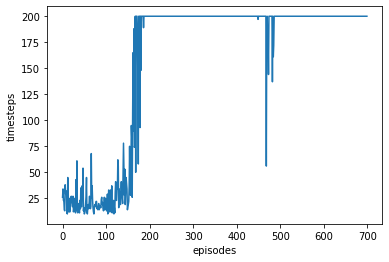

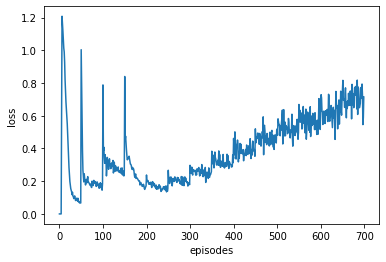

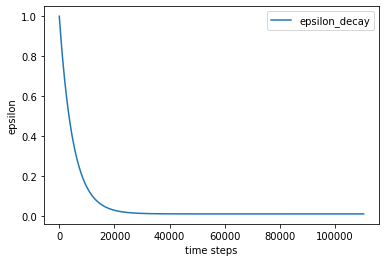

In [ ]:
episodes = np.arange(700)
y1 = episodic_timesteps
y2 = episodic_loss
#print(y2.size())
fig1,ax1 = plt.subplots()
ax1.plot(episodes,y1,label='reward')
ax1.set_xlabel('episodes')
ax1.set_ylabel('timesteps')

f1g2,ax2 = plt.subplots()
ax2.plot(episodes,y2,label='loss')
ax2.set_xlabel('episodes')
ax2.set_ylabel('loss')

fig3,ax3 = plt.subplots()
x3 = np.arange(steps_done)
ax3.plot(x3,epsilon_list,label='epsilon_decay')
ax3.set_xlabel('time steps')
ax3.set_ylabel('epsilon')

plt.legend()
plt.show()

Text(0.5, 1.0, 'Testing')

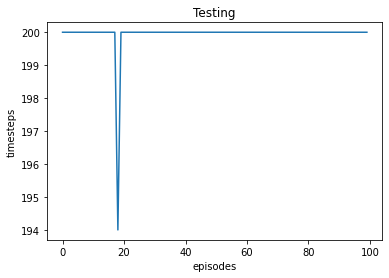

In [ ]:
env = gym.make('CartPole-v0')
env.reset()


def test_model():
    test_timesteps = []
    learn_model.eval()
    for ep in range(100):
        done = False
        t = 0
        state = env.reset()
        while not done:
            with torch.no_grad():
                state = torch.Tensor(state)
                act_val = learn_model(state)
                action = int(torch.argmax(act_val))

            new_state, rew, done, info = env.step(action)
            t += 1
            state = new_state

        test_timesteps.append(t)

    return test_timesteps

y4 = test_model()
episodes = np.arange(100)
fig4,ax4 = plt.subplots()
ax4.plot(episodes,y4,label='rewards')
ax4.set_xlabel('episodes')
ax4.set_ylabel('timesteps')
ax4.set_title('Testing')